# Geodesic Runtime

In [498]:
import jax.numpy as jnp

import os

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [499]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [501]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [522]:
figure_path = '../figures/geodesic_runtime/'

## Functions

In [526]:
def manifold_str(manifold, d):
    
    if manifold == "Sphere":
        return "\mathbb{S}^{"+f"{d}"+"}"
    elif manifold == "Ellipsoid":
        return "\mathrm{E}\\left( "+f"{d}"+" \\right)"
    elif manifold == "SPDN":
        return "\mathcal{P}\\left( "+f"{d}"+" \\right)"
    elif manifold == "T2":
        return "\mathbb{T}^{"+f"{d}"+"}"
    elif manifold == "H2":
        return "\mathbb{H}^{"+f"{d}"+"}"
    elif manifold == "celeba":
        return '\\text{VAE CelebA}'
    elif manifold == "svhn":
        return '\\text{VAE SVHN}'
    elif manifold == "mnist":
        return '\\text{VAE MNIST}'
    else:
        return ''.join(('\\text{', manifold, ' Distribution', '}')) 

In [527]:
def print_manifold_data(geometry, manifold, device, T, methods, path, display_iter=False):
    
    save_path = ''.join((path, manifold, '/'))
    
    onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
    onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]
    
    estimates = {}
    for file in onlyfiles:
        file_path = ''.join((save_path, file))
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        method = file.split(f'_{manifold}')[0]
        dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
        if dim in estimates:
            estimates[dim] = dict(estimates[dim], **values)
        else:
            estimates[dim] = values
            
        dims = list(estimates.keys())

        mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        length = [estimates[key3][key2]['length'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
        iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        error = []
        for key3, v3 in estimates.items():
            for key2, v2 in v3.items():
                val = estimates[key3][key2]
                if "error" in val.keys():
                    error.append(val['error'])
                else:
                    error.append(None)
        max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
        dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

        N_methods = len(list(set(method)))
        #dims = sum([[d]*N_methods for d in dims], [])
        
        dims = [int(key3) for key3, v3 in estimates.items()]
        dims.sort()
        dims = [str(d) for d in dims]
        
    for d in dims:
        print(f"${manifold_str(manifold, d)}$", end="")
        length = []
        iters = []
        mu_times = []
        std_times = []
        for m in methods:
            if m in estimates[d].keys():
                length.append(estimates[d][m]['length'])
                iters.append(estimates[d][m]['iterations'])
                mu_times.append(estimates[d][m]['mu_time'])
                std_times.append(estimates[d][m]['std_time'])
            else:
                length.append(jnp.nan)
                iters.append(jnp.nan)
                mu_times.append(jnp.nan)
                std_times.append(jnp.nan)
        length = jnp.stack(length)
        iters = jnp.stack(iters)
        mu_times = jnp.stack(mu_times)
        std_times = jnp.stack(std_times)
        best_length = jnp.where(length == jnp.nanmin(length))[0]
        best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
        best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
        for i in range(len(length)):
            if jnp.isnan(length[i]):
                l = '-'
                it = '-'
                mu_time = '-'
                std_time = '-'
                print(f" & ${l}$", end="")
                if display_iter:
                    print(f" & ${it}$", end="")
                print(f" & $-$", end="")
            else:
                if i in best_length:
                    print(f" & $\\pmb{{{length[i]:.4f}}}$", end="")
                else:
                    print(f" & ${length[i]:.4f}$", end="")
                if display_iter:
                    if i in best_iters:
                        print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
                    else:
                        print(f" & ${int(iters[i])}$", end="")
                if i in best_times:
                    print(f" & $\\pmb{{{mu_times[i]:.4f}}} \pm \\pmb{{ {std_times[i]:.4f} }}$", end="")
                else:
                    print(f" & ${mu_times[i]:.4f} \pm {std_times[i]:.4f}$", end="")
        print(" \\\ ")
    
    
    
    

In [528]:
def print_table_data(geometry, manifolds, device, T, methods, path, display_iter=False):
    
    for m in manifolds:
        print_manifold_data(geometry, m, device, T, methods, path, display_iter)
        print("\hline")
    

## Print Tables

In [545]:
methods = ['SGD', 'ADAM', 'GEORCE']
#methods = ['BFGS', 'ADAM', 'GEORCE']
#methods = ['SGD', 'CG', 'dogleg']
#methods = ['trust-ncg', 'trust-exact']

geometry = "finsler"
manifolds = ['Sphere', 'Ellipsoid', 'T2', 'H2', 'SPDN', 'Gaussian', 'Frechet', 'Cauchy', 'Pareto']
T = 50
device = 'gpu'
display_iter=False

path = f'timing_{device}/{geometry}/'

print_table_data(geometry, manifolds, device, T, methods, path, display_iter)

$\mathbb{S}^{2}$ & $1.7109$ & $0.7553 \pm 0.0038$ & $\pmb{1.6383}$ & $0.7882 \pm 0.0028$ & $1.6385$ & $\pmb{0.0483} \pm \pmb{ 0.0011 }$ \\ 
$\mathbb{S}^{3}$ & $1.8925$ & $0.7502 \pm 0.0021$ & $1.7300$ & $0.7701 \pm 0.0035$ & $\pmb{1.7297}$ & $\pmb{0.0518} \pm \pmb{ 0.0015 }$ \\ 
$\mathbb{S}^{5}$ & $2.1279$ & $0.9605 \pm 0.0027$ & $1.6875$ & $0.9817 \pm 0.0012$ & $\pmb{1.6868}$ & $\pmb{0.1402} \pm \pmb{ 0.0024 }$ \\ 
$\mathbb{S}^{10}$ & $2.3586$ & $1.1295 \pm 0.0006$ & $1.4013$ & $1.1307 \pm 0.0065$ & $\pmb{1.3908}$ & $\pmb{0.1709} \pm \pmb{ 0.0027 }$ \\ 
$\mathbb{S}^{20}$ & $2.4105$ & $1.5225 \pm 0.0028$ & $1.0829$ & $1.5356 \pm 0.0014$ & $\pmb{1.0560}$ & $\pmb{0.2691} \pm \pmb{ 0.0031 }$ \\ 
$\mathbb{S}^{50}$ & $2.1971$ & $1.3847 \pm 0.0033$ & $0.7427$ & $1.4288 \pm 0.0030$ & $\pmb{0.3508}$ & $\pmb{0.0643} \pm \pmb{ 0.0024 }$ \\ 
$\mathbb{S}^{100}$ & $1.8917$ & $2.5748 \pm 0.0030$ & $0.5511$ & $2.5551 \pm 0.0031$ & $\pmb{0.2626}$ & $\pmb{0.0877} \pm \pmb{ 0.0036 }$ \\ 
$\mathbb{S}^{25

## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [556]:
device = 'cpu'
geometry = "riemannian"
T = 100
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/geodesic_runtime/'

In [557]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [558]:
manifold = "Sphere"
save_path = ''.join((path, f"{manifold}", '/'))

In [559]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [560]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in sphere_estimates:
        sphere_estimates[dim] = dict(sphere_estimates[dim], **values)
    else:
        sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [561]:
manifold = "Ellipsoid"
save_path = ''.join((path, f"{manifold}", '/'))

In [562]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [563]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in ellipsoid_estimates:
        ellipsoid_estimates[dim] = dict(ellipsoid_estimates[dim], **values)
    else:
        ellipsoid_estimates[dim] = values

## Table Comparison

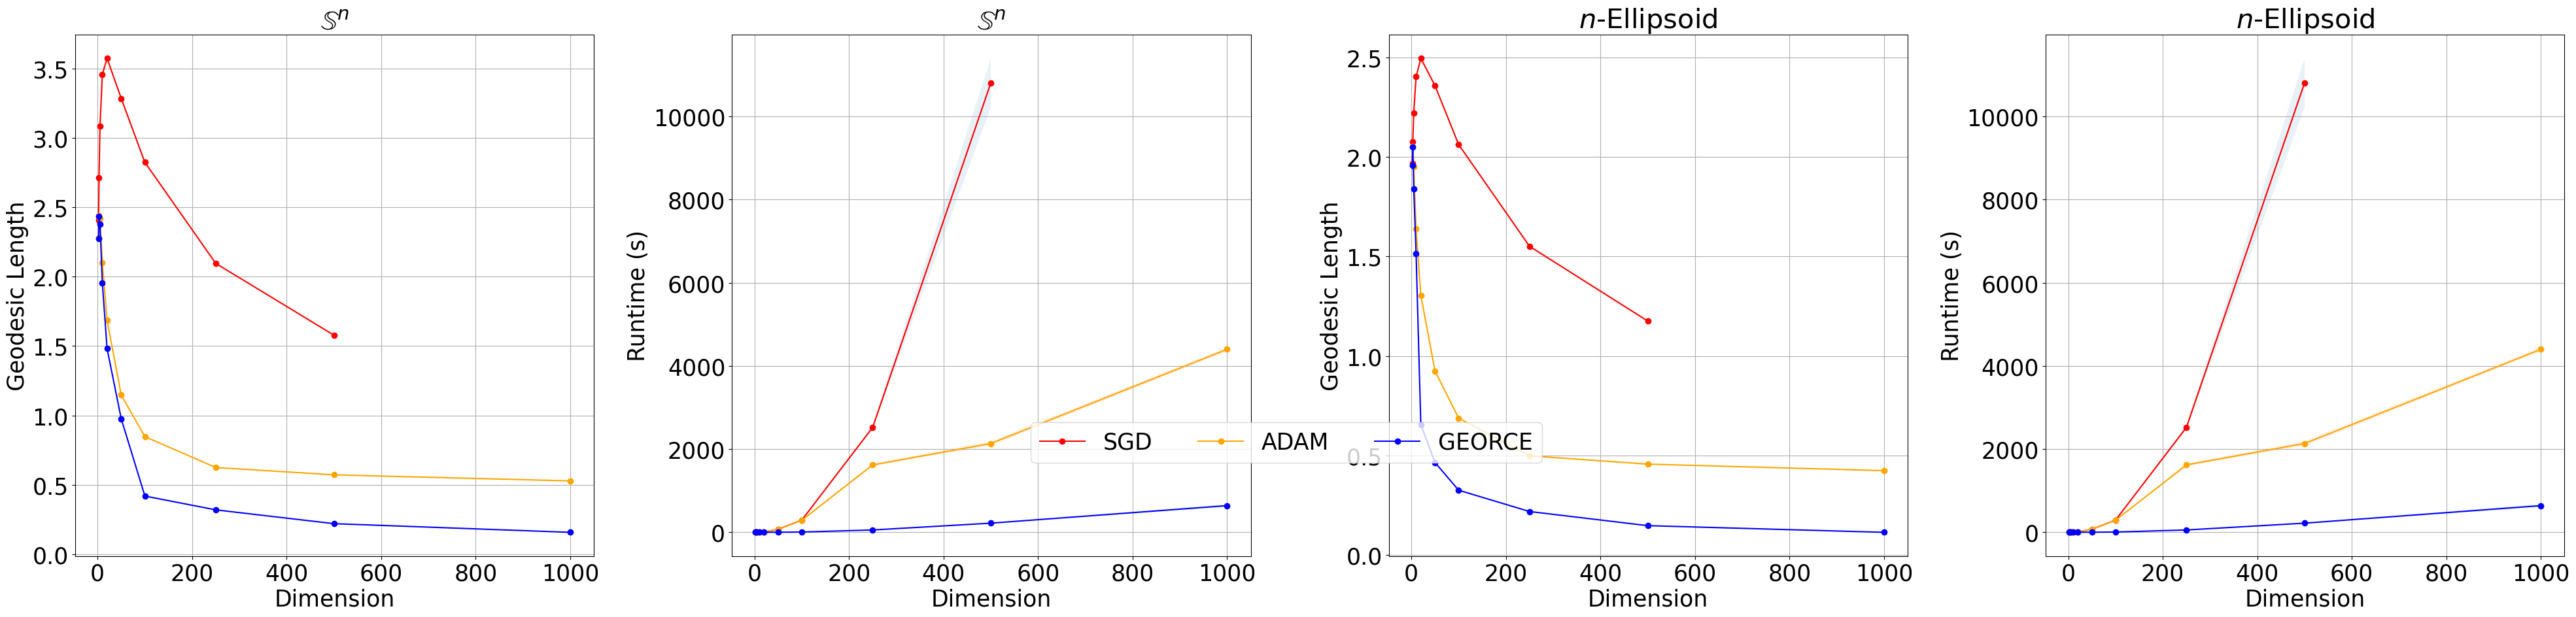

In [570]:
color = ['red', 'orange', 'blue']
methods = ['SGD', 'ADAM', 'GEORCE']
dims = [2,3,5,10,20,50,100, 250, 500, 1000]

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(141)
for j in range(len(methods)):
    vals = []
    for d in dims:
        try:
            bool_val = 'length' in sphere_estimates[str(d)][methods[j]].keys()
            if 'length' in sphere_estimates[str(d)][methods[j]].keys():
                vals.append(sphere_estimates[str(d)][methods[j]]['length'])
            else:
                vals.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)
    
ax = fig.add_subplot(142)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        try:
            bool_val = 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys()
            if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
                vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
            else:
                vals.append(jnp.nan)
                vals2.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Runtime (s)')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)

ax = fig.add_subplot(143)
for j in range(len(methods)):
    vals = []
    for d in dims:
        try:
            bool_val = 'length' in ellipsoid_estimates[str(d)][methods[j]].keys() 
            if 'length' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['length'])
            else:
                vals.append(jnp.nan)
        except:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)
    
ax = fig.add_subplot(144)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        try:
            bool_val = 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys()
            if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
                vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
            else:
                vals.append(jnp.nan)
                vals2.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j], label=methods[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Runtime (s)')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.25), ncol=5)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')